## A.Sentiment Analysis Using Fear & Greed Index

### 1.Load and clean sentiment data

In [2]:
import pandas as pd

# Load sentiment data
df = pd.read_csv("../data/fear_greed_sentiment.csv")
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


,date,fear_greed_score,sentiment_label
0,2024-06-19,64,Greed
1,2024-06-20,60,Greed
2,2024-06-21,63,Greed
3,2024-06-22,53,Neutral
4,2024-06-23,55,Greed


### 2.Apply numeric scoring to sentiment labels 

In [3]:
# Map sentiment label to numeric scale (optional for modeling)
sentiment_map = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_map)
df.head()


,date,fear_greed_score,sentiment_label,sentiment_numeric
0,2024-06-19,64,Greed,3
1,2024-06-20,60,Greed,3
2,2024-06-21,63,Greed,3
3,2024-06-22,53,Neutral,2
4,2024-06-23,55,Greed,3


### 3.Plot sentiment over time

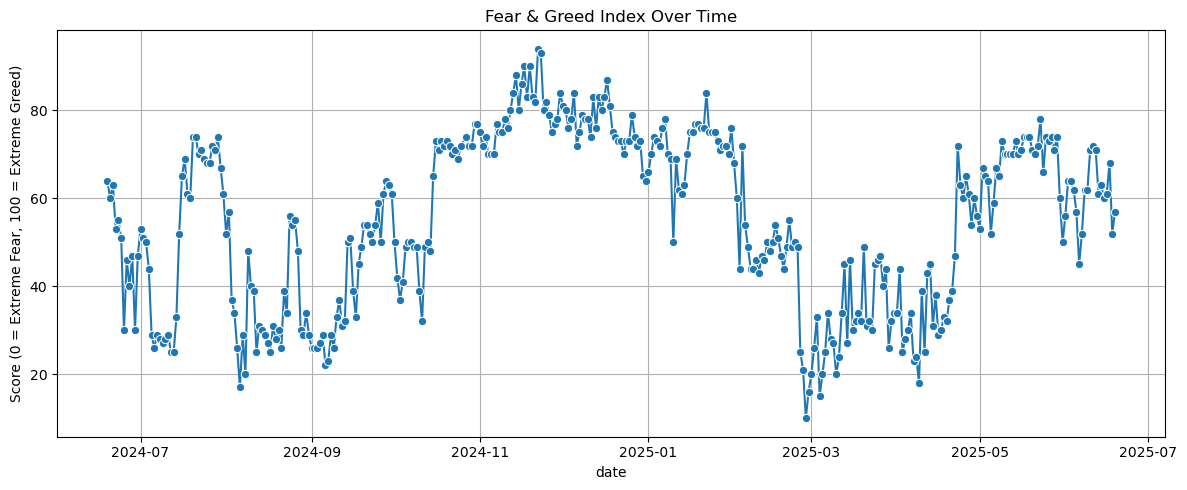

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='fear_greed_score', data=df, marker='o')
plt.title('Fear & Greed Index Over Time')
plt.ylabel('Score (0 = Extreme Fear, 100 = Extreme Greed)')
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/fear_greed_trend.png")
plt.show()


### 4.Merge with price data

In [20]:
import pandas as pd

# Step 1: Load and preprocess sentiment data
sentiment_df = pd.read_csv("../data/fear_greed_sentiment.csv")
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Step 2: Define coin details
coin_info = {
    "bitcoin": "../data/bitcoin.csv",
    "ethereum": "../data/ethereum.csv",
    "solana": "../data/solana.csv",
    "cardano": "../data/cardano.csv"
}

# Step 3: Function to load price data and merge with sentiment
def merge_sentiment_with_price(coin_name, file_path, sentiment_df):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['timestamp'])
    df.set_index('date', inplace=True)
    
    # Calculate returns
    df['returns'] = df[f"{coin_name}_price"].pct_change()
    
    # Reset index for merge
    df = df[['returns']].reset_index()

    # Merge with sentiment
    merged_df = pd.merge(sentiment_df, df, on='date', how='inner')
    return merged_df

# Step 4: Merge for all coins
merged_data = {}

for coin, path in coin_info.items():
    merged_data[coin] = merge_sentiment_with_price(coin, path, sentiment_df)

# Optional: Save merged outputs
for coin in merged_data:
    merged_data[coin].to_csv(f"outputs/{coin}_merged_sentiment.csv", index=False)


### 5.Plot Sentiment Score Over Time

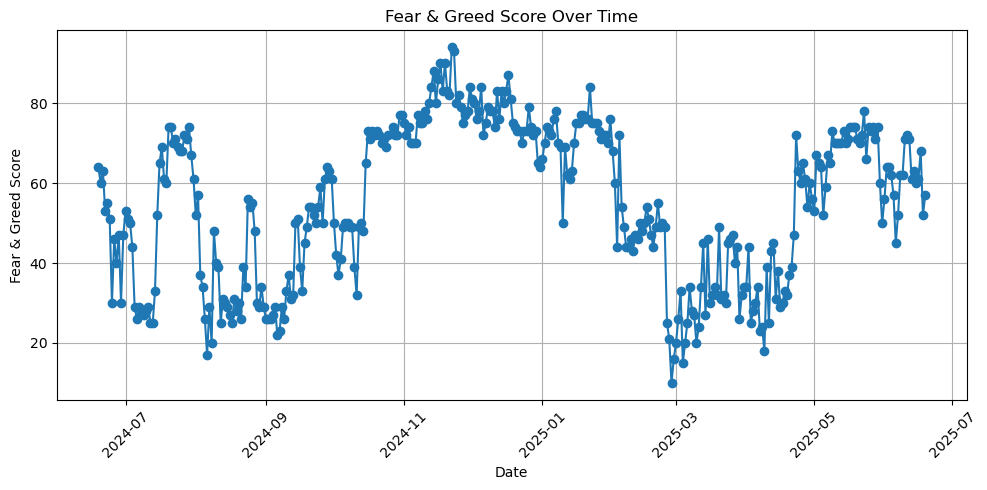

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sentiment_df['date'], sentiment_df['fear_greed_score'], marker='o')
plt.title("Fear & Greed Score Over Time")
plt.xlabel("Date")
plt.ylabel("Fear & Greed Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/fear_greed_trend.png")
plt.show()


### 6.Correlation Between Sentiment and Returns

In [25]:
import numpy as np

# Step: Compute correlation between sentiment score and returns
for coin, df in merged_data.items():
    # Drop rows with NaN returns
    clean_df = df.dropna(subset=['returns', 'fear_greed_score'])
    
    # Calculate correlation
    correlation = np.corrcoef(clean_df['fear_greed_score'], clean_df['returns'])[0, 1]
    
    print(f"📊 Correlation between Fear & Greed Score and {coin.title()} Returns: {correlation:.4f}")


📊 Correlation between Fear & Greed Score and Bitcoin Returns: 0.2544
📊 Correlation between Fear & Greed Score and Ethereum Returns: 0.2600
📊 Correlation between Fear & Greed Score and Solana Returns: 0.1876
📊 Correlation between Fear & Greed Score and Cardano Returns: 0.1432


### 7.Save Final Output

In [26]:
sentiment_df.to_csv("../data/fear_greed_price_merged.csv", index=False)
print("✅ Saved merged dataset for future modeling.")


✅ Saved merged dataset for future modeling.


### 8.Granger Causality Test

In [30]:
from statsmodels.tsa.stattools import grangercausalitytests

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Set max lags to test
max_lag = 5

# Loop through all merged sentiment+price data
for coin, df in merged_data.items():
    print(f"\n🔍 Granger Causality Test for {coin.capitalize()}:")
    
    # Drop rows with NaN (required for Granger test)
    test_df = df[['fear_greed_score', 'returns']].dropna()

    try:
        # Granger test: Does sentiment help predict returns?
        result = grangercausalitytests(test_df, maxlag=max_lag, verbose=True)
    except Exception as e:
        print(f"⚠️ Could not run Granger test for {coin}: {e}")



🔍 Granger Causality Test for Bitcoin:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6339  , p=0.0574  , df_denom=356, df_num=1
ssr based chi2 test:   chi2=3.6645  , p=0.0556  , df=1
likelihood ratio test: chi2=3.6460  , p=0.0562  , df=1
parameter F test:         F=3.6339  , p=0.0574  , df_denom=356, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9116  , p=0.1494  , df_denom=353, df_num=2
ssr based chi2 test:   chi2=3.8773  , p=0.1439  , df=2
likelihood ratio test: chi2=3.8565  , p=0.1454  , df=2
parameter F test:         F=1.9116  , p=0.1494  , df_denom=353, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1109  , p=0.0265  , df_denom=350, df_num=3
ssr based chi2 test:   chi2=9.5192  , p=0.0231  , df=3
likelihood ratio test: chi2=9.3945  , p=0.0245  , df=3
parameter F test:         F=3.1109  , p=0.0265  , df_denom=350, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

## B.Sentiment-Based Classification (ML Models)

### 1.Load Sentiment Dataset

In [31]:
import pandas as pd

# Load sentiment data
df = pd.read_csv("../data/fear_greed_sentiment.csv")
df['date'] = pd.to_datetime(df['date'])

# Optional: Drop NA and preview
df.dropna(inplace=True)
df.head()


,date,fear_greed_score,sentiment_label
0,2024-06-19,64,Greed
1,2024-06-20,60,Greed
2,2024-06-21,63,Greed
3,2024-06-22,53,Neutral
4,2024-06-23,55,Greed


### 2.Encode Target (Sentiment Label)

In [32]:
# Map sentiment_label to numeric for classification
label_mapping = {'Fear': 1, 'Neutral': 2, 'Greed': 3}
df['label'] = df['sentiment_label'].map(label_mapping)


### 3. Feature Engineering (Use lagged returns)

In [35]:
features_df['date'] = pd.to_datetime(features_df['date'])  # make sure this is datetime

for coin, df in merged_data.items():
    coin_df = df.copy()
    coin_df['date'] = pd.to_datetime(coin_df['date'])      # FIX: convert to datetime
    coin_df = coin_df[['date', 'returns']]
    coin_df.rename(columns={'returns': f'{coin}_returns'}, inplace=True)

    # Merge
    features_df = pd.merge(features_df, coin_df, on='date', how='inner')

# Drop rows with missing values
features_df.dropna(inplace=True)


### 4.from sklearn.model_selection import train_test_split

In [36]:
from sklearn.model_selection import train_test_split

X = features_df[['bitcoin_returns', 'ethereum_returns', 'solana_returns', 'cardano_returns']]
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 5.Train Models

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.36      0.44      0.40        18
         2.0       0.00      0.00      0.00        11
         3.0       0.56      0.62      0.59        29

    accuracy                           0.45        58
   macro avg       0.31      0.36      0.33        58
weighted avg       0.39      0.45      0.42        58



### 6.Save Outputs + Plot Feature Importance

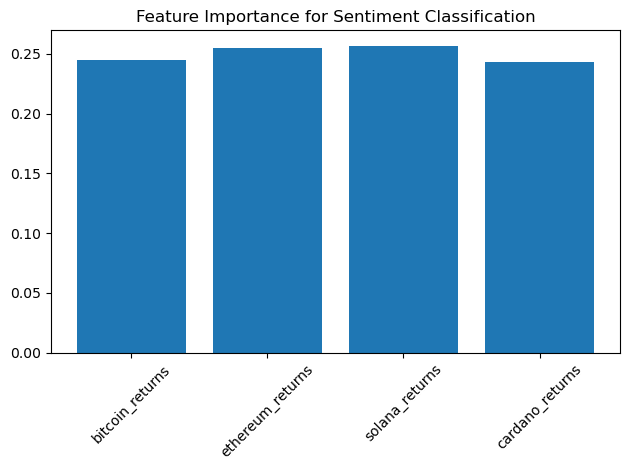

In [38]:
import matplotlib.pyplot as plt

# Plot feature importance
importances = model.feature_importances_
plt.bar(X.columns, importances)
plt.title("Feature Importance for Sentiment Classification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/feature_importance.png")
plt.show()